In [1]:
%matplotlib inline

import numpy as np
from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
from IPython.display import Image

from matplotlib import animation, rc
from IPython.display import HTML

C:\Users\gorei\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Physics 5300 Final
By: Ishan Gore

## Gravitational orbits in Cartesian coordinates

We can define a two-body orbit in 2D cartesian coordinates (letting the orbit happen in one plane). Defining our two bodies to have mass $m_1$ and $m_2$ with gravitational constant $G$ and specifying the respective generalized coordinates to be $x_1, y_1, x_2,$ and $y_2$, we get the energies to be:

$\begin{align}
  U(x_1, y_1, x_2, y_2) = - \frac{G m_1 m_2}{|r_{1,2}|} = - \frac{G m_1 m_2}{\sqrt{(x_1-x_2)^2 + (y_1 - y_2)^2}}
\end{align}$

$\begin{align}
  T(x_1, y_1, x_2, y_2) = \frac{1}{2}m_1 (x_1^2 + y_1^2) + \frac{1}{2}m_2 (x_2^2 + y_2^2)
\end{align}$

This consequently gives us our Lagrangian:
$\begin{align}
  \mathcal{L} = \frac{1}{2}m_1 (\dot{x_1}^2 + \dot{y_1}^2) + \frac{1}{2}m_2 (\dot{x_2}^2 + \dot{y_2}^2) + \frac{G m_1 m_2}{\sqrt{(x_1-x_2)^2 + (y_1 - y_2)^2}}
\end{align}$

From this, we can create our Euler-Lagrance equations:

$\begin{align}
  \frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot{x_1}} = \frac{\partial \mathcal{L}}{\partial x_1} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;
  \frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot{y_1}} = \frac{\partial \mathcal{L}}{\partial y_1}
\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;
  \frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot{x_2}} = \frac{\partial \mathcal{L}}{\partial x_2} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;
  \frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot{y_2}} = \frac{\partial \mathcal{L}}{\partial y_2}
\end{align}$

We can then use the substitution $z_1 = \dot{x}_1, \; \dot{z}_1 = \ddot{x}_1, \; z_2 = \dot{y}_1, \; \dot{z}_2 = \ddot{y}_1, \; z_3 = \dot{x}_2, \; \dot{z}_3 = \ddot{x}_2, \; z_4 = \dot{y}_2, \; \dot{z}_4 = \ddot{y}_2$

Then after simplifying the above equations we get the following definitions for $\dot{z}_i$:

$\begin{align}
  \ddot{x}_1 = \frac{G m_2 (x_2-x_1)}{|r_{1,2}|^3}
\end{align}$

$\begin{align}
  \ddot{y}_1 = \frac{G m_2 (y_2-y_1)}{|r_{1,2}|^3}
\end{align}$

$\begin{align}
  \ddot{x}_2 = - \frac{G m_1 (x_2-x_1)}{|r_{1,2}|^3}
\end{align}$

$\begin{align}
  \ddot{y}_2 = - \frac{G m_1 (y_2-y_1)}{|r_{1,2}|^3}
\end{align}$

                         where $|r_{1,2}| = \sqrt{(x_1-x_2)^2 + (y_1 - y_2)^2}$

With these equations in hand we can now code up our system...

In [2]:
class GravitationalOrbits():
    """
    Class to implement two particles orbiting each other using 
    Lagrange's equations.
    
    Parameters:
    m1 : float
        mass of body 1
    m2 : float
        mass of body 2
    G : float
        gravitational constant
        
    Methods:
    dz_dt(t,z)
        returns the right side of the differential equation in vector z, 
        given time t and the correpsonding value of z.
    """
    
    def __init__(self, m1=1., m2=1., G=1.):
        self.m1 = m1
        self.m2 = m2
        self.G = G
    
    def dz_dt(self, t, z):
        """
        Returns the right-hand side of te differential equation: 
        [dz/dt, d^2z/dt^2]
        
        Parameters:
        t : float
            time
        z : float
            8-component vector with:
                z[0] = x_1(t), z[1] = x_dot_1(t)
                z[2] = y_1(t), z[3] = y_dot_1(t)
                z[4] = x_2(t), z[5] = x_dot_2(t)
                z[6] = y_2(t), z[7] = y_dot_2(t)
        """
        
        r_12 = np.sqrt( (z[0] - z[4])**2 + (z[2] - z[6])**2 )
        return [ \
            z[1], self.G*self.m2 * (z[4]-z[0]) / r_12**3, \
            z[3], self.G*self.m2 * (z[6]-z[2]) / r_12**3, \
            z[5], -self.G*self.m1 * (z[4]-z[0]) / r_12**3, \
            z[7], -self.G*self.m1 * (z[6]-z[2]) / r_12**3, \
        ]
    
    def solve_ode(self, t_pts, z_0, abserr=1.0e-8, relerr=1.0e-8):
        """
        Solve the ODE given ICs. Specify errors to get more precision.
        """
        solution = solve_ivp(self.dz_dt, (t_pts[0], t_pts[-1]), 
                             z_0, t_eval=t_pts, method='RK23', 
                            atol=abserr, rtol=relerr)
        x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = solution.y
        
        return x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2
    
    def solve_ode_Leapfrog(self, t_pts, z_0):
        """
        Solve the ODE given ICs using the Leapfrog method.
        """
        delta_t = t_pts[1]-t_pts[0]
        
        x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0 = z_0
        
        # initialize the arrays with zeros
        num_t_pts = len(t_pts)
        
        x_1 = np.zeros(num_t_pts)
        x_dot_1 = np.zeros(num_t_pts)
        x_dot_1_half = np.zeros(num_t_pts)
        
        y_1 = np.zeros(num_t_pts)
        y_dot_1 = np.zeros(num_t_pts)
        y_dot_1_half = np.zeros(num_t_pts)
        
        x_2 = np.zeros(num_t_pts)
        x_dot_2 = np.zeros(num_t_pts)
        x_dot_2_half = np.zeros(num_t_pts)
        
        y_2 = np.zeros(num_t_pts)
        y_dot_2 = np.zeros(num_t_pts)
        y_dot_2_half = np.zeros(num_t_pts)
        
        # initial conditions
        x_1[0] = x_1_0
        x_dot_1[0] = x_dot_1_0
        
        y_1[0] = y_1_0
        y_dot_1[0] = y_dot_1_0
        
        x_2[0] = x_2_0
        x_dot_2[0] = x_dot_2_0
        
        y_2[0] = y_2_0
        y_dot_2[0] = y_dot_2_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts-1):
            t = t_pts[i]
            
            z = [x_1[i], x_dot_1[i], y_1[i], y_dot_1[i], x_2[i], x_dot_2[i], y_2[i], y_dot_2[i]]
            out = self.dz_dt(t,z)
            
            x_dot_1_half[i] = x_dot_1[i] + out[1] * delta_t/2
            x_1[i+1] = x_1[i] + x_dot_1_half[i]*delta_t
            
            y_dot_1_half[i] = y_dot_1[i] + out[3] * delta_t/2
            y_1[i+1] = y_1[i] + y_dot_1_half[i]*delta_t
            
            x_dot_2_half[i] = x_dot_2[i] + out[5] * delta_t/2
            x_2[i+1] = x_2[i] + x_dot_2_half[i]*delta_t
            
            y_dot_2_half[i] = y_dot_2[i] + out[7] * delta_t/2
            y_2[i+1] = y_2[i] + y_dot_2_half[i]*delta_t
            
            z = [x_1[i+1], x_dot_1[i], y_1[i+1], y_dot_1[i+1], x_2[i+1], x_dot_2[i+1], y_2[i+1], y_dot_2[i+1]]
            out = self.dz_dt(t,z)
            
            x_dot_1[i+1] = x_dot_1_half[i] + out[1]*delta_t/2
            y_dot_1[i+1] = y_dot_1_half[i] + out[3]*delta_t/2
            x_dot_2[i+1] = x_dot_2_half[i] + out[5]*delta_t/2
            y_dot_2[i+1] = y_dot_2_half[i] + out[7]*delta_t/2
            
        return x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2
    
    def solve_ode_leapfrog_n(self, t_pts, z_0):
        """
        Solve ODE given initial conditions and Leapfrog method for an arbitrary number of points.
        """
        
        delta_t = t_pts[1] - t_pts[0]
        
        # initialize the z array with zeros
        num_t_pts = len(t_pts)
        n_tot = len(z_0)
        z = np.zeros( shape=(n_tot, num_t_pts) )
        dot_half = np.zeros( int(n_tot/2) )
        
        # initialize conditions
        z[:,0] = z_0
        
        # step through the differential equation
        for i in np.arange(num_t_pts - 1):
            t = t_pts[i]
            
            z_now = z[:,i]
            out = np.asarray( self.dz_dt(t,z_now) )
            
            dot_half = z_now[1::2] + out[1::2]*delta_t/2
            z[0::2, i+1] = z_now[0::2] + dot_half*delta_t
            
            z_now[0::2] = z[0::2, i+1]
            out = np.asarray( self.dz_dt(t,z_now) )
            
            z[1::2, i+1] = dot_half + out[1::2]*delta_t/2
        
        return z
    
    def calc_E(self, z):
        """
        Calculates total Energy of system
        """
        x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = z
        
        r_12 = np.sqrt( (x_1 - x_2)**2 + (y_1 - y_2)**2 )
        
        T = self.m1*(x_dot_1**2 + y_dot_1**2)/2 + self.m2*(x_dot_2**2 + y_dot_2**2)/2
        U = -self.G*self.m1*self.m2 / r_12
        
        return T + U

In [3]:
def plot_y_vs_x(x, y, axis_labels=None, label=None, title=None, 
                color=None, linestyle=None, semilogy=False, loglog=False,
                ax=None):
    """
    Generic plotting function: return a figure axis with a plot of y vs. x,
    with line color and style, title, axis labels, and line label
    """
    if ax is None:        # if the axis object doesn't exist, make one
        ax = plt.gca()

    if (semilogy):
        line, = ax.semilogy(x, y, label=label, 
                            color=color, linestyle=linestyle)
    elif (loglog):
        line, = ax.loglog(x, y, label=label, 
                          color=color, linestyle=linestyle)
    else:
        line, = ax.plot(x, y, label=label, 
                    color=color, linestyle=linestyle)

    if label is not None:    # if a label if passed, show the legend
        ax.legend()
    if title is not None:    # set a title if one if passed
        ax.set_title(title)
    if axis_labels is not None:  # set x-axis and y-axis labels if passed  
        ax.set_xlabel(axis_labels[0])
        ax.set_ylabel(axis_labels[1])

    return ax, line

In [4]:
def start_stop_indices(t_pts, plot_start, plot_stop):
    start_index = (np.fabs(t_pts-plot_start)).argmin()  # index in t_pts array 
    stop_index = (np.fabs(t_pts-plot_stop)).argmin()  # index in t_pts array 
    return start_index, stop_index

#### Part a:
With the methods, we can now solve the 2-body problem and plot the orbit

In [5]:
# labels for individual plot axes
orbit_labels = (r'$x$', r'$y$')

# plotting time
t_start = 0.
t_end = 10.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)

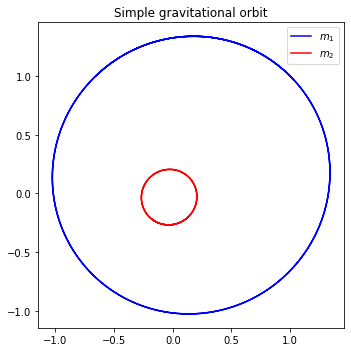

In [6]:
G = 1.
m1 = 1.
m2 = 5.

# instantiate a set of orbits
o1 = GravitationalOrbits(m1, m2, G)

# make initial conditions such that COM has 0 velocity
x_1_0, x_dot_1_0 = 1., -1.
y_1_0, y_dot_1_0 = 1., 1.
x_2_0, x_dot_2_0 = -(m1/m2)*x_1_0, -(m1/m2)*x_dot_1_0
y_2_0, y_dot_2_0 = -(m1/m2)*y_1_0, -(m1/m2)*y_dot_1_0

z_0 = [x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0]
x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = o1.solve_ode(t_pts, z_0)

# start the plot
fig = plt.figure(figsize=(5,5))
# overall_title = 'Simple gravitational orbit'
# fig.suptitle(overall_title, va='baseline')

# first plot: orbit
ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x_1, y_1, color='blue', label=r'$m_1$')
ax.plot(x_2, y_2, color='red', label=r'$m_2$')
ax.set_title('Simple gravitational orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()

#### Part b:
Now we can take m1 >> m2 to see how the system simplifies...

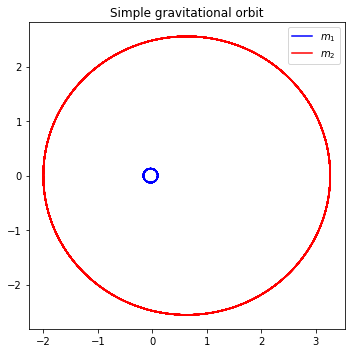

In [7]:
t_start = 0.
t_end = 20.
delta_t = 0.00001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)
G = 20.
m1 = 20.
m2 = 1.

# instantiate orbit class
o1 = GravitationalOrbits(m1,m2,G)

# make initial conditions such that COM has 0 velocity
x_1_0, x_dot_1_0 = 0.1, 0.
y_1_0, y_dot_1_0 = 0., 0.75
x_2_0, x_dot_2_0 = -(m1/m2)*x_1_0, -(m1/m2)*x_dot_1_0
y_2_0, y_dot_2_0 = -(m1/m2)*y_1_0, -(m1/m2)*y_dot_1_0

z_0 = [x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0]
x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = o1.solve_ode(t_pts, z_0)

# start the plot
fig = plt.figure(figsize=(5,5))
# overall_title = 'Simple gravitational orbit'
# fig.suptitle(overall_title, va='baseline')

# first plot: orbit
ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x_1, y_1, color='blue', label=r'$m_1$')
ax.plot(x_2, y_2, color='red', label=r'$m_2$')
ax.set_title('Simple gravitational orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()

We can see from this plot that if m1 >> m2, the orbits just reduces to the simple orbits we considered in class, where a planet makes circles around a stationary object.

#### Part d:
Let's first remake the plot from part a using the leapfrog method to verify that it works...

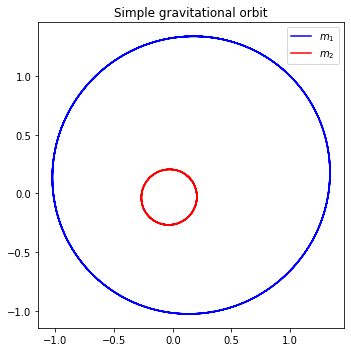

In [8]:
t_start = 0.
t_end = 20.
delta_t = 0.00001

t_pts = np.arange(t_start, t_end+delta_t, delta_t)
G = 1.
m1 = 1.
m2 = 5.

# instantiate a set of orbits
o1 = GravitationalOrbits(m1, m2, G)

# make initial conditions such that COM has 0 velocity
x_1_0, x_dot_1_0 = 1., -1.
y_1_0, y_dot_1_0 = 1., 1.
x_2_0, x_dot_2_0 = -(m1/m2)*x_1_0, -(m1/m2)*x_dot_1_0
y_2_0, y_dot_2_0 = -(m1/m2)*y_1_0, -(m1/m2)*y_dot_1_0

z_0 = [x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0]
# get values using leapfrom
x_1_lf, x_dot_1_lf, y_1_lf, y_dot_1_lf, x_2_lf, x_dot_2_lf, y_2_lf, y_dot_2_lf = o1.solve_ode_Leapfrog(t_pts, z_0)
# get values using scipy ODE
x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = o1.solve_ode(t_pts, z_0)

# start the plot
fig = plt.figure(figsize=(5,5))

# first plot: orbit
ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x_1_lf, y_1_lf, color='blue', label=r'$m_1$')
ax.plot(x_2_lf, y_2_lf, color='red', label=r'$m_2$')
ax.set_title('Simple gravitational orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()

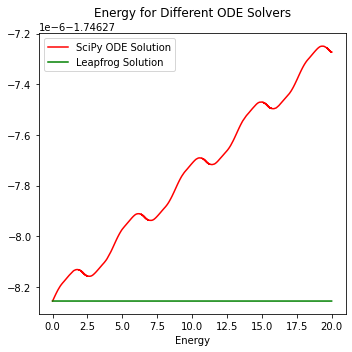

In [9]:
# start the plot
fig = plt.figure(figsize=(5,5))

# first plot: orbit
ax = fig.add_subplot(1,1,1)

ax.plot(t_pts, o1.calc_E([x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2]), 
        color='red', label='SciPy ODE Solution')
ax.plot(t_pts, o1.calc_E([x_1_lf, x_dot_1_lf, y_1_lf, y_dot_1_lf, x_2_lf, x_dot_2_lf, y_2_lf, y_dot_2_lf]), 
        color='green', label = 'Leapfrog Solution')

ax.legend()
ax.set_xlabel('Energy')
ax.set_title('Energy for Different ODE Solvers')

fig.tight_layout()

As we can see from this graph, the energy for the SciPy ODE solver definitely does not seem to be conserved, while it does appear to be conserved for the Leapfrog Algorithm.

#### Part f:
Let's animate the orbit now!

Let's first remake an orbit class with different initial conditions

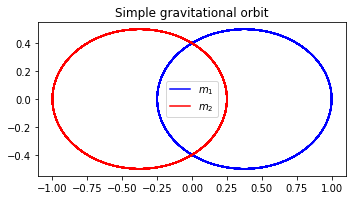

In [10]:
t_start = 0.
t_end = 50.
delta_t = 0.01

t_pts = np.arange(t_start, t_end+delta_t, delta_t)
G = 10.
m1 = 1.
m2 = 1.

# instantiate orbit class
o1 = GravitationalOrbits(m1,m2,G)

# make initial conditions such that COM has 0 velocity
x_1_0, x_dot_1_0 = 1., 0.
y_1_0, y_dot_1_0 = 0., 1.
x_2_0, x_dot_2_0 = -(m1/m2)*x_1_0, -(m1/m2)*x_dot_1_0
y_2_0, y_dot_2_0 = -(m1/m2)*y_1_0, -(m1/m2)*y_dot_1_0

z_0 = [x_1_0, x_dot_1_0, y_1_0, y_dot_1_0, x_2_0, x_dot_2_0, y_2_0, y_dot_2_0]
x_1, x_dot_1, y_1, y_dot_1, x_2, x_dot_2, y_2, y_dot_2 = o1.solve_ode(t_pts, z_0)

# start the plot
fig = plt.figure(figsize=(5,5))
# overall_title = 'Simple gravitational orbit'
# fig.suptitle(overall_title, va='baseline')

# first plot: orbit
ax = fig.add_subplot(1,1,1)

start, stop = start_stop_indices(t_pts, t_start, t_end)
ax.plot(x_1, y_1, color='blue', label=r'$m_1$')
ax.plot(x_2, y_2, color='red', label=r'$m_2$')
ax.set_title('Simple gravitational orbit')
ax.legend()
ax.set_aspect(1)

fig.tight_layout()

Now let's make the animation

In [11]:
%%capture

x_min = -1.2
x_max = -x_min
y_min = -1.2
y_max = -y_min

fig_anim = plt.figure(figsize=(5,3), num='Gravitational Orbit')
ax_anim = fig_anim.add_subplot(1,1,1)
ax_anim.set_xlim(x_min,x_max)
ax_anim.set_ylim(y_min,y_max)

# By assigning the first return form plot to line_anim, we can later change the values in the line
ln1_anum, = ax_anim.plot(x_1, y_1, color='blue')
ln2_anum, = ax_anim.plot(x_2, y_2, color='red')

pt1_anim, = ax_anim.plot(x_1[0], y_1[0], 'o', markersize=8, color='blue')
pt2_anim, = ax_anim.plot(x_2[0], y_2[0], 'o', markersize=8, color='red')

ax_anim.set_aspect(1)
ax_anim.axis('off')
fig_anim.tight_layout()

In [12]:
def animate_orbits(i):
    """
    Function to create each frame i.
    """
    i_skip = 1*i
    
    pt1_anim.set_data(x_1[i_skip], y_1[i_skip])
    pt2_anim.set_data(x_2[i_skip], y_2[i_skip])
    
    return (pt1_anim, pt2_anim)

In [13]:
frame_interval = 10.
frame_number = 1001
anim = animation.FuncAnimation(fig_anim,
                              animate_orbits,
                              init_func=None,
                              frames=frame_number,
                              interval=frame_interval,
                              blit=True,
                              repeat=False)

In [14]:
HTML(anim.to_jshtml())